In [0]:
import random
import networkx as nx
import matplotlib.pyplot as plt
from operator import itemgetter


In [2]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131289 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.6-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.6-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.6-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [4]:
!ls drive

'273-Project(Team+4+)-API-Documentation (1).desktop'
'273-Project(Team+4+)-API-Documentation (1).docx'
'Book report.desktop'
'Class notes.desktop'
'cmpe220 assgn 2.desktop'
 CMPE256_assignment1_deepika.desktop
 CMPE256_datasets
 CMPE256.desktop
 CMPE256_Individual.desktop
 CMPE256_Individual_finalReport.desktop
 CMPE256_IndividualProject_deepika.desktop
 CMPE256_Team11.desktop
 CMPE256_Team11_FinalPPT.desktop
 CMPE256_Team11.pptx
 cmpe256_team.desktop
 CMPE272_deepika_doc.desktop
'CMPE272-NLG & NLQ_deepika.desktop'
 CMPE273-Lab3-012443886.desktop
'CMPE 273_Refresher Assignment.desktop'
'Colab Notebooks'
 data
 DeepikaChowdarySDEResume_2018_ms.pdf
 Deepika_Yannamani_oncampus.pdf
 Deepika_Yannamani_Resume.desktop
'Deepika_Yannamani_Resume.desktop (7672d471)'
'Deepika_Yannamani_Resume.desktop (8109caf1)'
'Deepika_Yannamani_Resume.desktop (937bfe53)'
 Deepika_Yannamani_Resume.pdf
 Facebook_Dataset.txt
'Getting started'
 hourly_time_sheet.desktop
 hourly_time_sheet.xls
 Kouda_Lab2_Report.de

In [0]:
G2 = nx.read_edgelist('drive/Facebook_Dataset.txt', create_using = nx.Graph(), nodetype = int)

In [0]:
def draw():
    nx.draw(G)
    plt.savefig("facebook.pdf")
    plt.show()


def friends(graph, user):
    return set(graph.neighbors(user))


def friends_of_friends(graph, user):
    x=[]
    for each in graph.neighbors(user):
        for item in graph.neighbors(each):
            x.append(item)
    return set(x)
   
def common_friends(graph, user1, user2):
    x1 = friends(graph, user1)
    x2 = friends(graph, user2)
    return set(x1&x2)
    

def number_of_common_friends_map(graph, user):
    new_dict = dict()
    for each in graph.nodes():
        if(each!=user):
            if(each not in graph.neighbors(user)):
                new_dict[each] = len(common_friends(graph,each,user))
    return new_dict


def number_map_to_sorted_list(map):
    map = sorted(map.items(), key = itemgetter(1), reverse=True)
    return map


def recommend_by_number_of_common_friends(graph, user):
  
    diction = dict()
    diction = number_of_common_friends_map(graph,user)
    diction = number_map_to_sorted_list(diction)
    recommendations = []
    for i in range(0,10):
        recommendations.append(diction[i])
    return recommendations


def calc_score(graph, user, each):
    score = 0
    common = common_friends(graph, user, each)
    for item in common:
        score = score + 1/(len(friends(graph, item)))
    return score
    
    
def influence_map(graph, user):
    influence_scores = dict()
    for each in graph.nodes():
        if(each != user):
            score = calc_score(graph, user, each)
            influence_scores[each] = score
    return influence_scores
    

def recommend_by_influence(graph, user):
    recommendations = []
    d=influence_map(graph,user)
    d = sorted(d.items(), key = itemgetter(1), reverse=True)
    for i in range(0,10):
        recommendations.append(d[i])
    return recommendations


def return_pure_list(recommendations):
    pure_list = []
    for each in recommendations:
        pure_list.append(each[0])
    return pure_list



def compute_avg_rank(G):
    avg=0
    AVG=0
    l=[]
    for i in range(0,1000):
        f1 = random.choice(G.nodes())
        f2 = random.choice(G.nodes())
        if(f1!=f2):
            if(G.has_edge(f1,f2)):
                G.remove_edge(f1,f2)
                l1 = recommend_by_number_of_common_friends(G,f1)
                l2 = recommend_by_number_of_common_friends(G,f2)
                L1 = recommend_by_influence(G,f1)
                L2 = recommend_by_influence(G,f2)
                if f1 in return_pure_list(l2) and f2 in return_pure_list(l1):
                    r1 = return_pure_list(l2).index(f1)
                    r2 = return_pure_list(l1).index(f2)
                    avg=avg+(r1+r2)/2
                if f1 in return_pure_list(L2) and f2 in return_pure_list(L1):
                    R1 = return_pure_list(L2).index(f1)
                    R2 = return_pure_list(L1).index(f2)
                    AVG=AVG+(R1+R2)/2
        G.add_edge(f1,f2)
    l.append(avg)
    l.append(AVG)
    print("Average Rank of Method 1: ")
    print(l[0])
    print("Average rank of Method 2: ")
    print(l[1])
    return l



def same_and_different_recommendations(graph):
    res=[]
    count_same, count_diff = 0,0
    for i in range(0,4039):
        l1,l2 = [], []
        l1 = return_pure_list(recommend_by_number_of_common_friends(graph, i))
        l2 = return_pure_list(recommend_by_influence(graph, i))
        if(l1 == l2):
            count_same = count_same + 1
        else:
            count_diff = count_diff +1
    res.append(count_same)
    res.append(count_diff)
    print("Number of Same recommendations from both methods: ")
    print(res[0])
    print("Number of different recommendations from both methods: ")
    print(res[1])
    return res
 
    
def most_common(lst):
    return max(set(lst), key=lst.count)



def predict_lonely_nodes(graph):
    res_2=[]
    alones=[]
    for i in range(0,graph.number_of_nodes()):
        l_2 = return_pure_list(recommend_by_influence(graph,i))
        res_2.append(l_2[9])
    print("Lonely Nodes: ")
    for i in range(0,10):
        lonely = most_common(res_2)
        alones.append(lonely)
        res_2.remove(lonely)
    new_dict = dict()
    for i in range(0,10):
        new_dict[alones[i]] = nx.clustering(graph, alones[i])
    print(new_dict)
    return alones
    

def show(graph, user):
    nx.draw_networkx_nodes(graph,pos=nx.spring_layout(graph),
                       nodelist=return_pure_list(recommend_by_influence(graph,user)),
                       node_color='b',
                       node_size=500,
                   alpha=0.8)
    plt.savefig('x.pdf')
    print("Recommendation by Method 1: " )
    print(recommend_by_influence(graph, user))
    print("Recommendation by Method 2: ")
    print(recommend_by_number_of_common_friends(graph, user))


Recommendation by Method 1: 
[(862, 0.6908911995020903), (698, 0.6863519630887088), (3437, 0.3557297126038576), (865, 0.30637254901960786), (868, 0.30637254901960786), (3495, 0.199994840958673), (3684, 0.19824414067856097), (3797, 0.1945961698623275), (3721, 0.17551686795128826), (3592, 0.16849482023156612)]
Recommendation by Method 2: 
[(3501, 6), (3577, 6), (3633, 6), (3684, 6), (3948, 6), (1085, 5), (3609, 5), (3677, 5), (3721, 5), (3692, 5)]


TypeError: ignored

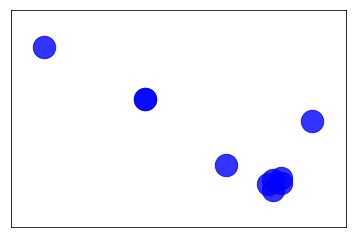

In [7]:
show(G2,857 )
compute_avg_rank(G2)
same_and_different_recommendations(G2)
predict_lonely_nodes(G2)

In [0]:
same_and_different_recommendations(G2)